### Code to generate inference data tiles to test pytorch deeplab model.  This code reads in xml and WSI pair and then locates the region with annotations, then creates 1024 x 1024 tiles of the raw WSI, the mask (0~12 as label), and the binary mask (tells you where annotation is) **only** when there is an annotation in the tile field-of-view. **Also fixes native resolution to 1um/pixel to match resolution of the images that were originally trained on.**

(Some funtions from xml2trainingdata.ipynb, but some functions edited for specific use.)

In [2]:
OPENSLIDE_PATH = r'C:\Users\Kevin\Downloads\openslide-win64-20230414\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import openslide
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from matplotlib import pyplot as plt
import skimage.measure
import matplotlib.pyplot as plt
import scipy.stats as stats
import torchvision.transforms as transforms
from glob import glob
from time import time
from skimage.measure import label

In [3]:
# First, input xml_filepath and output a dataframe of X,Y coordinates in general. (can be used for ROI as well)
def xml_to_df(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    append_df = []
    for index, Annotation in enumerate(root.iter("Annotation")):
        for Region in Annotation.iter('Region'):
            x = np.array([Vertex.get('X') for Vertex in Region.iter('Vertex')])
            y = np.array([Vertex.get('Y') for Vertex in Region.iter('Vertex')])
            id = np.array([int(Region.get('Id'))])
            classnames = index + 1
            coord_dict = {"ClassNames": [classnames], "X": [x], "Y": [y], "ID": [id]}
            df = pd.DataFrame(data = coord_dict)
            df.ID = df.ID.astype(int)
            append_df.append(df)
    coord_df = pd.concat(append_df).reset_index(drop=True)
    return(coord_df)

In [4]:
# Then, input xml_path to use xml_to_df function to output X,Y coordinates for each annotation per class:
def coord_to_multiclass_df(xml_path):
    coord_df = xml_to_df(xml_path)
    coord_df = coord_df.drop(columns = ["ID"])
    dict = {"corneum" : 1,"spinosum": 2,"hairshaft":3,"hairfollicle":4,"smoothmuscle":5,"oil":6,"sweat":7,"nerve":8,"bloodvessel":9,"ecm":10,"fat":11,"white":12}
    coord_df = coord_df.replace({"ClassNames": dict})
    return coord_df

In [5]:
# Then input original image and the coord_df to output the mask with unique annotations (1..N, N = 12 in this case):
def create_mask_multi_annot(xml_path, image_path):
    slide = openslide.open_slide(image_path)
    target_level = slide.get_best_level_for_downsample(1) #downsample factor = 1 for this case all the time
    target_dim_orig = (slide.level_dimensions[target_level][1],slide.level_dimensions[target_level][0])
    rsf = 1/0.4416
    target_dim = (int(target_dim_orig[0]/rsf),int(target_dim_orig[1]/rsf))
    mask = np.zeros(target_dim, dtype = np.uint8)
    iter_order = [2,10,5,4,6,11,7,9,8,12,3,1]
    coord_df = coord_to_multiclass_df(xml_path) #use function above

    for i in iter_order:
        coord_df_tmp = coord_df[coord_df.ClassNames == i]
        for idx, row in coord_df_tmp.iterrows():
            xx = row.X.astype(float).astype('int32')
            yy = row.Y.astype(float).astype('int32')
            contours = np.array(list(zip(xx,yy)))
            contours = contours/rsf
            class_number = row.ClassNames
            mask = cv2.fillPoly(mask, pts=[contours.astype(int)], color=(int(class_number)))
    return mask, rsf

In [15]:
# cv2 method:
# Input xml and image path and output mask and image with only the regions with annotations in it:
def create_binary_mask_label(xml_path, image_path):
    mask, rsf = create_mask_multi_annot(xml_path, image_path)
    binary_mask = mask > 0 # np.unique(mask) gives 0~12
    rows, cols = np.where(binary_mask)
    min_row = np.min(rows) - 800
    max_row = np.max(rows) + 800
    min_col = np.min(cols) - 800
    max_col = np.max(cols) + 800
    bbox_size = (max_col-min_col,max_row-min_row) #update bbox_size
    max_col -= bbox_size[0] % 1024
    max_row -= bbox_size[1] % 1024
    bbox_size = (max_col-min_col,max_row-min_row)
    print(f"Min Row: {min_row}")
    print(f"Max Row: {max_row}")
    print(f"Min Column: {min_col}")
    print(f"Max Column: {max_col}")
    binary_mask_bbox = binary_mask[min_row:max_row, min_col:max_col]
    slide = openslide.OpenSlide(image_path)
    aa = int(min_col * rsf)
    bb = int(min_row * rsf)
    orig_top_left = (aa,bb) # level 0 original top left bbox
    cc = int((max_col-min_col)*rsf)
    dd = int((max_row-min_row)*rsf)
    orig_bbox_size =  (cc,dd)
    image = slide.read_region(location = orig_top_left,level=0,size=orig_bbox_size) #open original level image only for bbox:
    image = np.array(image)
    image = image[:,:,:3]
    image_resized = cv2.resize(image,bbox_size,interpolation=cv2.INTER_AREA)
    mask_bbox = mask[min_row:max_row, min_col:max_col]
    return binary_mask_bbox, image_resized, mask_bbox, bbox_size #returns binary roi mask bbox (0 or 1), H&E image bbox, and mask bbox (0~12) of same size.

In [13]:
def generate_inference_data(xml_src,img_src, image_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\he_tiles",mask_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\mask_tiles", binary_mask_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\bin_mask_tiles"):
    binary_mask_bbox, image_bbox, mask_bbox, bbox_size = create_binary_mask_label(xml_src,img_src)
    wsi_name = os.path.basename(img_src).replace(".ndpi","")
    plt.imshow(mask_bbox)
    plt.show()
    cols, rows = bbox_size
    count = 0
    for i in range(0, rows, 1024):
        for j in range(0, cols, 1024):
            binary_mask_tile = binary_mask_bbox[i:i+1024, j:j+1024]
            if np.sum(binary_mask_tile) > 50:
                count += 1
                image_tile = image_bbox[i:i+1024, j:j+1024,:]
                mask_tile = mask_bbox[i:i+1024, j:j+1024]
                image_tile_save_path = os.path.join(image_save_path,wsi_name)
                mask_tile_save_path = os.path.join(mask_save_path,wsi_name)
                bin_mask_tile_save_path = os.path.join(binary_mask_save_path,wsi_name)
                Image.fromarray(image_tile).save(image_tile_save_path + "_" + str(count) + ".png")
                Image.fromarray(mask_tile).save(mask_tile_save_path + "_" + str(count) + ".png")
                Image.fromarray(binary_mask_tile.astype(np.uint8)).save(bin_mask_tile_save_path + "_" + str(count) + ".png")
            else: # no annotations in this tile
                continue

Min Row: 10493
Max Row: 18685
Min Column: 14973
Max Column: 21117


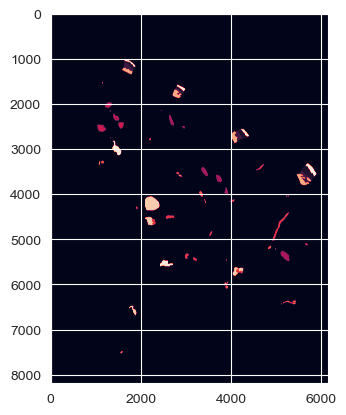

In [14]:
# xml_src = r"\\shelter\Kyu\skin_aging\clue_cohort\wsi\2022-06-14 15.39.21.xml"
# img_src = r"\\shelter\Kyu\skin_aging\clue_cohort\wsi\2022-06-14 15.39.21.ndpi"
# generate_inference_data(xml_src,img_src,image_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\he_tiles",   mask_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\mask_tiles", binary_mask_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\bin_mask_tiles")

In [ ]:
# code to check overlay of mask if accurate:
rgb_image = Image.open(r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\he_tiles\2022-06-14 15.39.21_1.png")
mask_image = Image.open(r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\mask_tiles\2022-06-14 15.39.21_1.png")
mask_image = mask_image.convert("1")
mask_array = np.array(mask_image)
rgb_array = np.array(rgb_image)
overlayed_image = rgb_array.copy()
overlay_color = [0, 255, 0]  #green
overlayed_image[mask_array == 1] = overlay_color
result_image = Image.fromarray(overlayed_image)
result_image.show()

Min Row: 3918
Max Row: 17230
Min Column: 105
Max Column: 17513


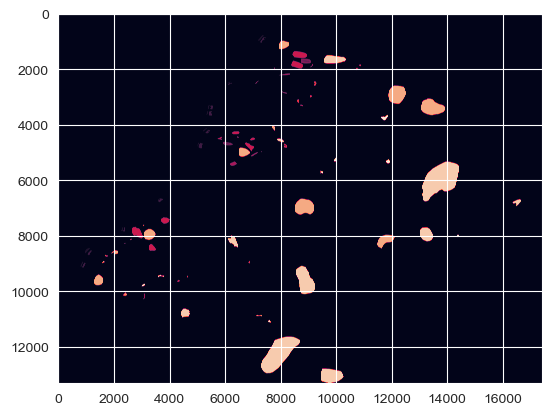

In [16]:
xml_src = r"\\shelter\Kyu\skin_aging\clue_cohort\wsi\2022-06-16 17.21.16.xml"
img_src = r"\\shelter\Kyu\skin_aging\clue_cohort\wsi\2022-06-16 17.21.16.ndpi"
generate_inference_data(xml_src,img_src,image_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\he_tiles",   mask_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\mask_tiles", binary_mask_save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\bin_mask_tiles")